# Generate mitgcm input data BUMP B3
Note: Endianness of the binary files written here is not explicitly set and will depend on the machine you are working on. Use [numpy.dtype.newbyteorder](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.newbyteorder.html) to explicitly set the endianness or compile mitgcm such that the machine default will be used.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from os import mkdir
import gsw
import gvpy.gvimport as gvi

In [2]:
import warnings
warnings.filterwarnings('ignore')

It seems like float64 is the default data type in numpy, but let's be clear about this and write a little test/conversion function.

In [3]:
def CheckFloat64(x):
    if x.dtype == np.float64:
        print('its a float64')
    else:
        print('converting to float64')
        x = x.astype(np.float64)
    return x

In [4]:
try:
    mkdir('fig/')
except:
    print('fig/'+' already exists')

Basic geometry for this case is 100 vertical levels and 8*250 horizontal levels

In [5]:
nx = 1
ny = 2000
nz = 100

## Horizontal resolution

In [6]:
a = np.linspace(1000, 50, 500, dtype=np.float64)
b = np.squeeze(np.ones((1, 1000), dtype=np.float64))*50
c = np.linspace(50, 1000, 500, dtype=np.float64)

dy = np.hstack((a,b,c))
# unlike Matlab cumsum np.cumsum preserves input shape
y  = np.cumsum(dy)
y  = y - y[999]

# make sure dy is a float64
dy = CheckFloat64(dy)
# save to binary file
with open("delYvar", 'wb') as f:
    dy.tofile(f)

its a float64


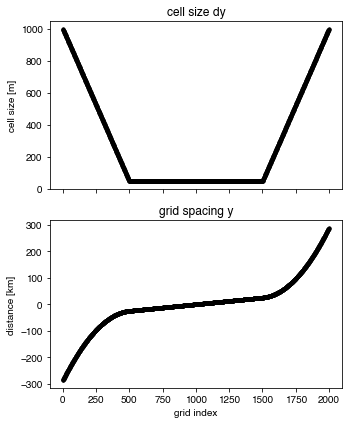

In [7]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,6))
ax[0].plot(dy, 'k.')
ax[0].set_title('cell size dy')
ax[0].set_ylabel('cell size [m]')

ax[1].plot(y/1000, 'k.')
ax[1].set_title('grid spacing y')
ax[1].set_ylabel('distance [km]')
ax[1].set_xlabel('grid index')


plt.tight_layout()
plt.savefig('fig/dy_and_y.pdf')

## Vertical resolution

In [8]:
# from bottom up - start out with 20m resolution here
dz1 = np.ones(60)*20
rema = 2900 - np.sum(dz1)
xx = np.arange(1,41,1)+20
dz2 = xx*rema/np.sum(xx)
dz = np.hstack((dz1, dz2))
dz = np.flipud(dz)
z = np.cumsum(dz)
# make sure dz is in float64
dz = CheckFloat64(dz)
# save to binary file
with open("delZvar", 'wb') as f:
    dz.tofile(f)

its a float64


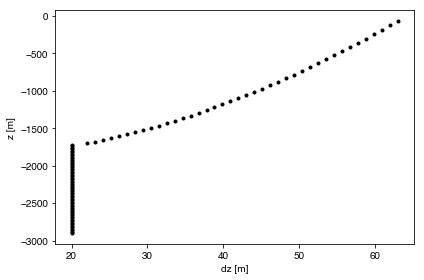

In [9]:
fig, ax = plt.subplots()
ax.plot(dz, -z, 'k.')
ax.set_ylabel('z [m]')
ax.set_xlabel('dz [m]')
plt.tight_layout()
plt.savefig('fig/dz.pdf')

## Bottom topography
Try some kind of Witch of Agnesi
$$
y = b \frac{a^3}{a^2+x^2}
$$

In [10]:
# steepness (smaller a is steeper)
a = 2000
# max height
b=500
topo = b* a**2/(a**2+y**2)-np.max(np.abs(z))
# make sure it's float64
topo = CheckFloat64(topo)
# save to binary
with open("topo.bin", 'wb') as f:
    topo.tofile(f)

its a float64


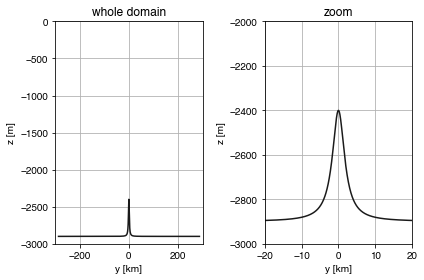

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(y/1e3,topo,'0.1')
ax[0].set(xlim=(-3e2,3e2),ylim=(-3000,0),xlabel='y [km]', ylabel='z [m]', title='whole domain')
ax[0].grid()

ax[1].plot(y/1e3,topo,'0.1')
ax[1].set(xlim=(-2e1,2e1),ylim=(-3000,-2000),xlabel='y [km]', ylabel='z [m]', title='zoom')
ax[1].grid()

plt.tight_layout()
plt.savefig('fig/topo.pdf')

In [12]:
xx = topo
bins = -z
inds = np.digitize(xx, bins)
topod = -z[inds]

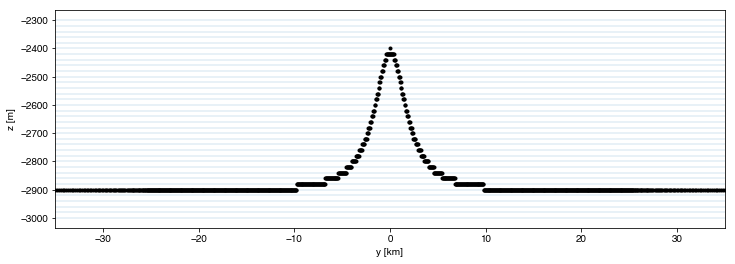

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
[ax.axhline(y=yy, linewidth=0.2) for yy in np.arange(-3000,-2280,20)]
ax.plot(y/1000, topod, 'k.')
ax.set_ylabel('z [m]')
ax.set_xlabel('y [km]')
ax.set_xlim([-35,35]);

## Stratification
Using a linear equation of state with $\alpha_T=2\times10^{-4}$ and a constant stratification set by $N=1\times10^{-6}$.

In [14]:
gravity = 9.81;
talpha = 2.0e-4;

Translate N$^2$ to linear equation of state.
$$
N^2 = -\frac{g}{\rho} \frac{d \rho}{dz}
$$
$$
\rho = \alpha_T \theta
$$
$$
T_{z0} = \frac{N^2}{g \alpha_T}
$$

In [15]:
N2 = np.ones_like(dz)*1e-6
# translate N2 to the linear equation of state
tz0 = N2/(gravity*talpha)
# integrate vertically
t = np.cumsum(-tz0*dz)
Tref = t-t[0]+3

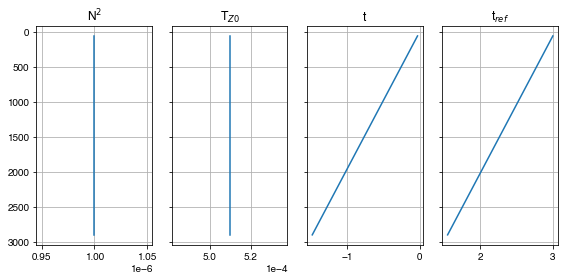

In [19]:
fig, ax = plt.subplots(1,4,sharey=True, figsize=(8,4))
ax[0].plot(N2,z)
ax[0].set_title('N$^2$')
ax[1].plot(tz0,z)
ax[1].set_title('T$_{Z0}$')
ax[2].plot(t,z)
ax[2].set_title('t')
ax[3].plot(Tref,z)
ax[3].set_title('t$_{ref}$')
ax[0].invert_yaxis()
for axi in ax:
    axi.grid()
plt.tight_layout()
plt.savefig('fig/n2-tref.pdf')

Save profiles for open boundary conditions

In [20]:
Tref = CheckFloat64(Tref)
# save to binary
with open("OB_North_T.bin", 'wb') as f:
    Tref.tofile(f)
# save to binary
with open("OB_South_T.bin", 'wb') as f:
    Tref.tofile(f)
# save to binary
with open("Tref", 'wb') as f:
    Tref.tofile(f)

its a float64


In [22]:
Tref.shape

(100,)

## Generate inital stratification
Turns out I can just use Tref generated above and don't need a whole field.

## Generate initial velocities

In [23]:
Vref = np.ones((nz))*0.02
Vref = CheckFloat64(Vref)
# save to binary
with open("OB_V.bin", 'wb') as f:
    Vref.tofile(f)

Vinit = np.ones([nx,ny,nz])*0.02
Vinit = CheckFloat64(Vinit)
# save to binary
with open("V.init", 'wb') as f:
    Vinit.tofile(f)

its a float64
its a float64


In [24]:
Vinit.shape

(1, 2000, 100)

## Scales

The topographic Froude number is calculated as
$$Fr=\frac{N H}{U}$$

In this run the parameters are $H=500$m, $N^2=1\times10^{-6}$ and $U=0.02$.

In [25]:
N = np.sqrt(N2[0])
H=500
U=0.02
Frtopo = N*H/U
print(Frtopo)

25.0
